## Packages & utils

In [1]:
import itertools

import numpy as np
import pandas as pd
from tqdm import tqdm
import lightgbm
import holidays

from sklearn.metrics import mean_squared_error

fr_holidays = holidays.CountryHoliday('FRA')

from vacances_scolaires_france import SchoolHolidayDates
school_holidays = SchoolHolidayDates()

## Données

In [2]:
nomenclature_produits = pd.read_csv('data/nomenclature_produits.csv')

points_de_vente = pd.read_csv('data/points_de_vente.csv')
prix_vente = pd.read_csv('data/prix_vente.csv')

prix_vente['ORD_PRIX'] = prix_vente['PRIX_UNITAIRE'].apply(lambda x: float(x.split(' ')[-1].replace('€', '')))

ventes_2018 = pd.read_csv('data/ventes_2018.csv.zip',
                          parse_dates=['DATE'])

In [3]:
artc_list = ventes_2018['ID_ARTC'].drop_duplicates().tolist()
pdv_list = ventes_2018['ID_PDV'].drop_duplicates().tolist()

In [4]:
dates = pd.date_range('2018-01-01', '2019-03-31')
combines = pd.DataFrame(itertools.product(artc_list, dates),
                        columns=['ID_ARTC', 'DATE']
                        )

In [5]:
dates_dataframe = combines[['DATE']].drop_duplicates()
dates_dataframe['holiday_zone_A'] = dates_dataframe['DATE'].dt.date\
                                    .apply(lambda x: school_holidays.is_holiday_for_zone(x, 'A'))
dates_dataframe['holiday_zone_B'] = dates_dataframe['DATE'].dt.date\
                                    .apply(lambda x: school_holidays.is_holiday_for_zone(x, 'B'))
dates_dataframe['holiday_zone_C'] = dates_dataframe['DATE'].dt.date\
                                    .apply(lambda x: school_holidays.is_holiday_for_zone(x, 'C'))

In [7]:
import warnings
warnings.filterwarnings("ignore")

## PDV model

In [7]:
from sklearn.linear_model import Ridge 
from sklearn.ensemble import StackingRegressor, BaggingRegressor

from catboost import CatBoostRegressor

In [9]:
errors_list = list()
test_list = list()

for pdv in tqdm(pdv_list):
    
    # extract data and add empty dates
    sub_ventes = ventes_2018.query(f'ID_PDV=={pdv}')\
                          .drop('ID_PDV', axis=1)\
                          .merge(combines, how='right')\
                          .fillna({'QTE': 0})
    sub_ventes['TRIMESTRE'] = sub_ventes['DATE'].dt.quarter
    sub_ventes['ANNEE'] = sub_ventes['DATE'].dt.year
    
    sub_ventes = sub_ventes.merge(nomenclature_produits)
    sub_ventes = sub_ventes.merge(prix_vente.query(f'ID_PDV=={pdv}')\
                                          .filter(
                                              ['ID_ARTC', 'ANNEE', 'TRIMESTRE', 'ORD_PRIX']
                                              )
                                          )
    
    # extract date 
    sub_ventes['WEEK_DAY'] = sub_ventes['DATE'].dt.dayofweek
    sub_ventes['DAY_OF_MONTH'] = sub_ventes['DATE'].dt.day
    sub_ventes['HOLIDAYS'] = sub_ventes['DATE'].apply(lambda x: x in fr_holidays)

    # create target
    sub_ventes['LOG_QTE'] = np.log1p(sub_ventes['QTE'])

    # encode categories
    sub_ventes['ID_ARTC'] = sub_ventes['ID_ARTC'].astype('category')
    sub_ventes['LB_VENT_RAYN'] = sub_ventes['LB_VENT_RAYN'].astype('category')
    sub_ventes['LB_VENT_FAML'] = sub_ventes['LB_VENT_FAML'].astype('category')
    sub_ventes['LB_VENT_SOUS_FAML'] = sub_ventes['LB_VENT_SOUS_FAML'].astype('category')
    sub_ventes['WEEK_DAY'] = sub_ventes['WEEK_DAY'].astype('category')
    
    # create train, val & test
    train = sub_ventes.query('ANNEE==2018 and TRIMESTRE<4')
    val = sub_ventes.query('ANNEE==2018 and TRIMESTRE==4')
    test = sub_ventes.query('ANNEE==2019 and TRIMESTRE==1')
    
    # train, valid
    cols = ['ID_ARTC', 'LB_VENT_RAYN', 'LB_VENT_FAML', 'LB_VENT_SOUS_FAML',
            'WEEK_DAY', 'DAY_OF_MONTH', 'ORD_PRIX', 'HOLIDAYS']
    target = 'LOG_QTE'
    
    model = lightgbm.LGBMRegressor(objective='regression_l2', n_estimators=100, n_jobs=-1, random_state=3105)
    model.fit(train[cols], train[target])
    val.loc[:,'preds'] = model.predict(val[cols]).clip(0)
    
    errors_list.append(np.sqrt(mean_squared_error(val['LOG_QTE'], val['preds'])))
    print(pdv, errors_list[-1])
    
    # re-train
    full_train = sub_ventes.query('ANNEE==2018 and TRIMESTRE<=4')
    model = lightgbm.LGBMRegressor(objective='regression_l2', n_estimators=100, n_jobs=-1)
    model.fit(full_train[cols], full_train[target])
    test.loc[:,'preds'] = model.predict(test[cols]).clip(0)
    test['ID_PDV'] = pdv
    
    test_list.append(test)

  0%|          | 0/149 [00:00<?, ?it/s]

102 0.48783767609877254


  1%|          | 1/149 [00:07<19:38,  7.97s/it]

5 0.41608177440617666


  1%|▏         | 2/149 [00:14<17:49,  7.28s/it]

87 0.49813938972417887


  2%|▏         | 3/149 [00:24<20:47,  8.54s/it]

118 0.47738451054372183


  3%|▎         | 4/149 [00:34<22:05,  9.14s/it]

39 0.606833421518746


  3%|▎         | 5/149 [00:47<25:02, 10.43s/it]

123 0.5625016346040942


  4%|▍         | 6/149 [00:58<24:59, 10.48s/it]

128 0.5142562749543139


  5%|▍         | 7/149 [01:07<24:13, 10.23s/it]

140 0.4748929111686804


  5%|▌         | 8/149 [01:16<23:04,  9.82s/it]

130 0.5162455008374702


  6%|▌         | 9/149 [01:29<25:06, 10.76s/it]

95 0.5109366459144353


  7%|▋         | 10/149 [01:40<25:02, 10.81s/it]

25 0.46301076045165795


  7%|▋         | 11/149 [01:44<20:14,  8.80s/it]

133 0.546564672363846


  8%|▊         | 12/149 [01:58<23:24, 10.25s/it]

63 0.5670103354080599


  9%|▊         | 13/149 [02:17<29:00, 12.80s/it]

146 0.4884265191068136


  9%|▉         | 14/149 [02:27<27:29, 12.22s/it]

90 0.4901088657364114


 10%|█         | 15/149 [02:42<28:54, 12.94s/it]

116 0.49496583416366896


 11%|█         | 16/149 [02:55<28:46, 12.98s/it]

73 0.4655587586005541


 11%|█▏        | 17/149 [03:03<25:27, 11.57s/it]

71 0.4545282510443907


 12%|█▏        | 18/149 [03:15<25:04, 11.48s/it]

23 0.4266159174346561


 13%|█▎        | 19/149 [03:24<23:32, 10.87s/it]

132 0.5198495836611294


 13%|█▎        | 20/149 [03:34<22:39, 10.54s/it]

33 0.4922508032006596


 14%|█▍        | 21/149 [03:40<19:21,  9.07s/it]

74 0.4834518876764269


 15%|█▍        | 22/149 [03:51<20:33,  9.71s/it]

144 0.5963094487566915


 15%|█▌        | 23/149 [04:08<25:14, 12.02s/it]

76 0.449760688130622


 16%|█▌        | 24/149 [04:16<22:44, 10.91s/it]

142 0.6035202756818044


 17%|█▋        | 25/149 [04:27<22:27, 10.87s/it]

31 0.5531699341106476


 17%|█▋        | 26/149 [04:34<19:36,  9.57s/it]

52 0.5018269785388689


 18%|█▊        | 27/149 [04:42<18:53,  9.29s/it]

96 0.49765781153943234


 19%|█▉        | 28/149 [04:58<22:36, 11.21s/it]

38 0.6402216430990803


 19%|█▉        | 29/149 [05:11<23:34, 11.78s/it]

143 0.6085145663157359


 20%|██        | 30/149 [05:21<22:26, 11.32s/it]

43 0.4717378900455591


 21%|██        | 31/149 [05:34<23:04, 11.73s/it]

89 0.49275148476472613


 21%|██▏       | 32/149 [05:44<21:36, 11.08s/it]

19 0.45993678546686634


 22%|██▏       | 33/149 [05:50<18:53,  9.77s/it]

110 0.4968043794363784


 23%|██▎       | 34/149 [05:57<17:06,  8.92s/it]

45 0.5467744426374803


 23%|██▎       | 35/149 [06:07<17:30,  9.22s/it]

122 0.5213589045880526


 24%|██▍       | 36/149 [06:19<18:48,  9.99s/it]

149 0.4918250697966241


 25%|██▍       | 37/149 [06:30<19:15, 10.32s/it]

66 0.5482989211952871


 26%|██▌       | 38/149 [06:40<18:35, 10.05s/it]

85 0.5612082898036861


 26%|██▌       | 39/149 [06:57<22:26, 12.24s/it]

60 0.5577560761363642


 27%|██▋       | 40/149 [07:08<21:30, 11.84s/it]

69 0.42592752512385035


 28%|██▊       | 41/149 [07:17<19:42, 10.95s/it]

131 0.5361395996910384


 28%|██▊       | 42/149 [07:31<21:03, 11.80s/it]

127 0.5937971267736565


 29%|██▉       | 43/149 [07:44<21:56, 12.42s/it]

36 0.558097843333706


 30%|██▉       | 44/149 [07:55<20:47, 11.88s/it]

35 0.5676460099972315


 30%|███       | 45/149 [08:12<23:02, 13.30s/it]

57 0.4567314860900275


 31%|███       | 46/149 [08:22<21:27, 12.50s/it]

65 0.4447434492801318


 32%|███▏      | 47/149 [08:32<20:01, 11.78s/it]

83 0.5740338238900953


 32%|███▏      | 48/149 [08:42<18:35, 11.04s/it]

120 0.5096933847706088


 33%|███▎      | 49/149 [08:52<18:09, 10.89s/it]

103 0.5125518433614903


 34%|███▎      | 50/149 [09:13<22:40, 13.74s/it]

70 0.5070570539137816


 34%|███▍      | 51/149 [09:24<21:09, 12.96s/it]

108 0.5231556810348297


 35%|███▍      | 52/149 [09:34<19:26, 12.03s/it]

29 0.519970756442975


 36%|███▌      | 53/149 [09:42<17:20, 10.84s/it]

82 0.4633810951962471


 36%|███▌      | 54/149 [09:51<16:38, 10.51s/it]

27 0.5381588512470452


 37%|███▋      | 55/149 [09:59<15:16,  9.75s/it]

136 0.509815888498598


 38%|███▊      | 56/149 [10:13<17:01, 10.98s/it]

9 0.4205213518026735


 38%|███▊      | 57/149 [10:22<15:38, 10.21s/it]

37 0.6003419092771167


 39%|███▉      | 58/149 [10:33<16:14, 10.71s/it]

26 0.5911442945098003


 40%|███▉      | 59/149 [10:42<15:11, 10.13s/it]

84 0.46789787478079403


 40%|████      | 60/149 [10:54<15:47, 10.64s/it]

7 0.3982240150347527


 41%|████      | 61/149 [11:05<15:45, 10.75s/it]

8 0.4308596635743223


 42%|████▏     | 62/149 [11:11<13:23,  9.23s/it]

79 0.5338846333049123


 42%|████▏     | 63/149 [11:20<13:16,  9.27s/it]

99 0.48181187726208186


 43%|████▎     | 64/149 [11:29<12:59,  9.17s/it]

34 0.5493771024441013


 44%|████▎     | 65/149 [11:46<16:00, 11.44s/it]

51 0.4534063797628115


 44%|████▍     | 66/149 [11:54<14:35, 10.55s/it]

28 0.45280575044465365


 45%|████▍     | 67/149 [11:59<12:08,  8.89s/it]

107 0.5864395626807819


 46%|████▌     | 68/149 [12:09<12:18,  9.12s/it]

93 0.5032704665316139


 46%|████▋     | 69/149 [12:20<13:01,  9.77s/it]

92 0.4899791113585253


 47%|████▋     | 70/149 [12:29<12:34,  9.56s/it]

94 0.48201413880513333


 48%|████▊     | 71/149 [12:39<12:38,  9.73s/it]

47 0.5490275481565826


 48%|████▊     | 72/149 [12:52<13:26, 10.47s/it]

18 0.4843460896056484


 49%|████▉     | 73/149 [12:57<11:29,  9.07s/it]

40 0.5785805536263356


 50%|████▉     | 74/149 [13:09<12:07,  9.70s/it]

86 0.5805104065355523


 50%|█████     | 75/149 [13:22<13:19, 10.81s/it]

139 0.5191648687717376


 51%|█████     | 76/149 [13:32<12:50, 10.55s/it]

114 0.5096163487257246


 52%|█████▏    | 77/149 [13:42<12:31, 10.44s/it]

67 0.47743069429822516


 52%|█████▏    | 78/149 [13:52<12:10, 10.28s/it]

72 0.4568506905303122


 53%|█████▎    | 79/149 [14:01<11:29,  9.84s/it]

109 0.5042845303717836


 54%|█████▎    | 80/149 [14:09<10:37,  9.25s/it]

115 0.4477214850698781


 54%|█████▍    | 81/149 [14:19<10:50,  9.56s/it]

64 0.5355016759167287


 55%|█████▌    | 82/149 [14:30<11:15, 10.08s/it]

78 0.4459852442444104


 56%|█████▌    | 83/149 [14:39<10:42,  9.74s/it]

41 0.5200890814272832


 56%|█████▋    | 84/149 [14:49<10:41,  9.87s/it]

106 0.5783733084554777


 57%|█████▋    | 85/149 [14:59<10:29,  9.84s/it]

97 0.5306277703452176


 58%|█████▊    | 86/149 [15:12<11:23, 10.85s/it]

58 0.5081119587046835


 58%|█████▊    | 87/149 [15:20<10:17,  9.95s/it]

147 0.5309367281109004


 59%|█████▉    | 88/149 [15:30<10:00,  9.85s/it]

91 0.4975515123920862


 60%|█████▉    | 89/149 [15:43<10:46, 10.78s/it]

134 0.5140311590944543


 60%|██████    | 90/149 [15:53<10:17, 10.47s/it]

55 0.5010528359527108


 61%|██████    | 91/149 [16:04<10:21, 10.71s/it]

68 0.5267368617466657


 62%|██████▏   | 92/149 [16:12<09:31, 10.03s/it]

30 0.5486041359854321


 62%|██████▏   | 93/149 [16:19<08:27,  9.07s/it]

98 0.4126529102492355


 63%|██████▎   | 94/149 [16:28<08:14,  9.00s/it]

81 0.4641410468556699


 64%|██████▍   | 95/149 [16:37<07:59,  8.88s/it]

88 0.42117813119223724


 64%|██████▍   | 96/149 [16:44<07:31,  8.51s/it]

10 0.3759989269437572


 65%|██████▌   | 97/149 [16:52<07:08,  8.25s/it]

32 0.46567509867104523


 66%|██████▌   | 98/149 [16:59<06:41,  7.88s/it]

62 0.5067470367488203


 66%|██████▋   | 99/149 [17:09<07:13,  8.68s/it]

11 0.41397932788686165


 67%|██████▋   | 100/149 [17:16<06:39,  8.15s/it]

117 0.4679923116782714


 68%|██████▊   | 101/149 [17:24<06:25,  8.03s/it]

48 0.4419806457478195


 68%|██████▊   | 102/149 [17:34<06:44,  8.61s/it]

2 0.4380124514311178


 69%|██████▉   | 103/149 [17:40<05:59,  7.82s/it]

105 0.47878407474695944


 70%|██████▉   | 104/149 [17:49<06:07,  8.17s/it]

121 0.54521013322708


 70%|███████   | 105/149 [18:01<06:44,  9.19s/it]

145 0.4180975087688807


 71%|███████   | 106/149 [18:10<06:32,  9.12s/it]

46 0.5219032646050219


 72%|███████▏  | 107/149 [18:19<06:33,  9.38s/it]

125 0.49386586780035785


 72%|███████▏  | 108/149 [18:32<07:05, 10.37s/it]

119 0.5305997110601428


 73%|███████▎  | 109/149 [18:42<06:47, 10.18s/it]

126 0.49567855737998123


 74%|███████▍  | 110/149 [18:53<06:41, 10.31s/it]

42 0.5073683286716795


 74%|███████▍  | 111/149 [19:01<06:09,  9.73s/it]

16 0.4138354591833127


 75%|███████▌  | 112/149 [19:09<05:37,  9.13s/it]

12 0.4481966862766639


 76%|███████▌  | 113/149 [19:15<04:58,  8.30s/it]

77 0.4445882132026906


 77%|███████▋  | 114/149 [19:22<04:39,  7.99s/it]

17 0.403270847567338


 77%|███████▋  | 115/149 [19:30<04:32,  8.03s/it]

50 0.47926639155402645


 78%|███████▊  | 116/149 [19:39<04:27,  8.11s/it]

100 0.4893537293491114


 79%|███████▊  | 117/149 [19:46<04:12,  7.89s/it]

113 0.5291163121002495


 79%|███████▉  | 118/149 [19:57<04:36,  8.91s/it]

101 0.4863364676007278


 80%|███████▉  | 119/149 [20:06<04:26,  8.88s/it]

56 0.5146287878356424


 81%|████████  | 120/149 [20:18<04:45,  9.84s/it]

22 0.4096394700342049


 81%|████████  | 121/149 [20:23<03:55,  8.40s/it]

138 0.4779747544705542


 82%|████████▏ | 122/149 [20:32<03:50,  8.55s/it]

53 0.48374646833045926


 83%|████████▎ | 123/149 [20:42<03:54,  9.01s/it]

124 0.4951257972061991


 83%|████████▎ | 124/149 [20:51<03:40,  8.81s/it]

61 0.4606673400845347


 84%|████████▍ | 125/149 [21:01<03:44,  9.35s/it]

24 0.3984914941987902


 85%|████████▍ | 126/149 [21:09<03:25,  8.95s/it]

75 0.42002063235851544


 85%|████████▌ | 127/149 [21:18<03:13,  8.81s/it]

137 0.46642774743218046


 86%|████████▌ | 128/149 [21:28<03:16,  9.34s/it]

135 0.49225144961620965


 87%|████████▋ | 129/149 [21:38<03:07,  9.39s/it]

20 0.5219374193852548


 87%|████████▋ | 130/149 [21:45<02:48,  8.86s/it]

104 0.5627524813880795


 88%|████████▊ | 131/149 [21:58<02:57,  9.86s/it]

148 0.47638097867940565


 89%|████████▊ | 132/149 [22:07<02:44,  9.69s/it]

15 0.450619411223243


 89%|████████▉ | 133/149 [22:14<02:22,  8.88s/it]

111 0.45768767274699673


 90%|████████▉ | 134/149 [22:24<02:18,  9.23s/it]

3 0.43559344853388965


 91%|█████████ | 135/149 [22:31<01:59,  8.57s/it]

49 0.4989774092347497


 91%|█████████▏| 136/149 [22:39<01:50,  8.50s/it]

21 0.46420094359529984


 92%|█████████▏| 137/149 [22:49<01:44,  8.75s/it]

80 0.48637497921138007


 93%|█████████▎| 138/149 [22:58<01:36,  8.79s/it]

1 0.445100286590518


 93%|█████████▎| 139/149 [23:03<01:17,  7.72s/it]

4 0.43359289384306365


 94%|█████████▍| 140/149 [23:13<01:15,  8.35s/it]

112 0.45516519523116933


 95%|█████████▍| 141/149 [23:20<01:04,  8.06s/it]

129 0.5092863986654828


 95%|█████████▌| 142/149 [23:32<01:04,  9.28s/it]

44 0.5849969923168482


 96%|█████████▌| 143/149 [23:42<00:57,  9.55s/it]

13 0.4081055097997473


 97%|█████████▋| 144/149 [23:49<00:43,  8.66s/it]

59 0.4983751328268349


 97%|█████████▋| 145/149 [23:59<00:36,  9.24s/it]

141 0.49501276435981095


 98%|█████████▊| 146/149 [24:09<00:27,  9.27s/it]

14 0.4412132484310485


 99%|█████████▊| 147/149 [24:15<00:16,  8.50s/it]

6 0.45793183521300584


 99%|█████████▉| 148/149 [24:24<00:08,  8.63s/it]

54 0.433686776298755


100%|██████████| 149/149 [24:31<00:00,  9.88s/it]


In [10]:
np.mean(errors_list)

0.49540064239322773

In [11]:
submission_file = pd.concat(test_list)

In [12]:
submission_file['raw_qte'] = np.expm1(submission_file['preds'].clip(0))
submission_file['qte'] = np.expm1(submission_file['preds'].clip(0)).round().astype(int)
submission_file['id'] = submission_file['ID_PDV'].astype(str) + "_" + \
                        submission_file['ID_ARTC'].astype(str) + '_' + \
                        submission_file['DATE'].dt.strftime('%Y%m%d').astype(str)

In [15]:
submission_file[['id', 'qte', 'raw_qte']].head()

,id,qte,raw_qte
365,102_398_20190101,0,0.281480
366,102_398_20190102,4,3.732222
367,102_398_20190103,3,3.163088
368,102_398_20190104,5,5.362372
369,102_398_20190105,5,5.492353


In [16]:
submission_file.query('qte!=0')[['id', 'qte']].to_csv('lgb_pdv_best.csv.zip', index=False, compression="zip")

In [17]:
submission_file[['id', 'qte', 'raw_qte']].to_csv('lgb_pdv_best_raw.csv.zip', index=False, compression="zip")

In [29]:
submission_file.sample()

,ID_ARTC,DATE,QTE,TRIMESTRE,ANNEE,LB_VENT_RAYN,LB_VENT_FAML,LB_VENT_SOUS_FAML,ORD_PRIX,PRIX_UNITAIRE,...,HOLIDAYS,holiday_zone_A,holiday_zone_B,holiday_zone_C,LOG_QTE,preds,ID_PDV,raw_qte,qte,id
978400,952,2019-01-27,0.0,1,2019,PAIN PAT LS INDUS,PATISSERIE LS TRADITIONNELLE,PATISSERIE LS TRADITIONNELLE - SS-FAML 3,NaN,NaN,...,False,False,False,False,0.0,-0.014194,131,0.0,0,131_952_20190127


<AxesSubplot:xlabel='DATE'>

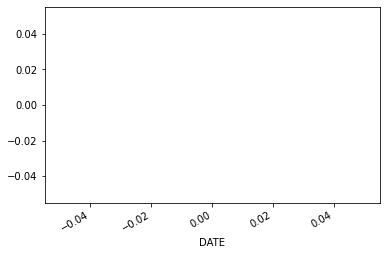

In [14]:
submission_file.query('ID_ARTC==952 and ID_PDV==131').set_index('DATE')['qte'].plot()